In [5]:
import tensorflow as tf ### models
import numpy as np ### math computations
import matplotlib.pyplot as plt ### plotting bar chart
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L2, L1
from tensorboard.plugins.hparams import api as hp
import sklearn
import cv2
import albumentations as A
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
from google.colab import drive
import io
import wandb
from wandb.keras import WandbCallback

## Wandb Install, Login, Initialization and Configuration

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: rember98cjs. Use `wandb login --relogin` to force relogin


In [4]:
pip install wandb==0.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6487 sha256=4ea111381f90b4183e5efcd1636923989b1df6b8edc556067ea8fb38f98deab9
  Stored in directory: /root/.cache/pip/wheels/64/19/61/d440ccd46a2a014bce61fc5c6c8495dedd32ef04cba8b34b28
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8790 sha256=814b05bbf0fb01d1a4211ce36b35e772a852fadf7fd3be29d5fb3d7f8eac3040
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee520

In [14]:
#wandb.init(project="Malaria-Detection", entity="rember98cjs")
#wandb.tensorboard.patch(root_logdir="./logs")
wandb.init(project="Malaria-Detection", entity="rember98cjs", sync_tensorboard=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
wandb.run

In [13]:
wandb.config = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 3,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32,
}
CONFIGURATION = wandb.config

In [ ]:
#wandb.finish()

## Data Preparation

###Data Loading

In [6]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteVEJEPJ/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [7]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset



In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

#dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [ ]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(115, 157, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

## Dataset Visualization

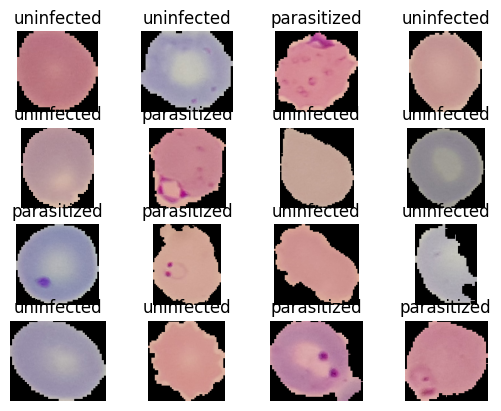

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [ ]:
#for i, (image, label) in enumerate(train_dataset.take(2)):
#  plt.subplot(1, 4, 2*i + 1)
#  plt.imshow(image)
#  plt.subplot(1, 4, 2*i + 2)
#  plt.imshow(tf.image.adjust_saturation(image, 0.3))

#  plt.title(dataset_info.features['label'].int2str(label))
#  plt.axis('off')

## Data Preprocessing

### Data augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)


In [ ]:
original_image, label = next(iter(train_dataset))

In [ ]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor= 0.3)

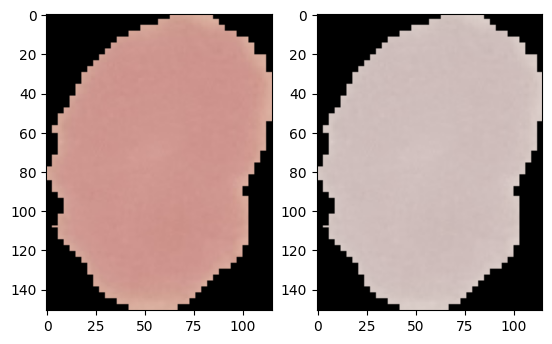

In [ ]:
visualize(original_image, augmented_image)

In [9]:
original_image, label = next(iter(train_dataset))

IM_SIZE = 224

@tf.function
def resize_rescale(image, label):

  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [10]:
tf.config.run_functions_eagerly(True)

In [11]:
### tf.image augment
@tf.function
def augment(image, label):

  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))
  #image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  #image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  image = tf.image.stateless_random_flip_left_right(image)

  return image, label

In [12]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()

  @tf.function
  def call(self, image):
    return tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))

In [13]:
### tf.keras.layer resizing and rescaling
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])

In [14]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal'),
])

@tf.function
def augment_layer(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [ ]:
#train_dataset = train_dataset.map(augment)
#val_dataset = val_dataset.map(resize_rescale_layers)
#test_dataset = test_dataset.map(resize_rescale_layers)

In [ ]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(145, 148, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [15]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [16]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [17]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Mixup Data Augmentation

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1
  return r_y, r_x, r_h, r_w


In [ ]:
def mixup(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*image_1 + (1-lamda)*image_2
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
  return image, label

In [ ]:
# def mixup(train_dataset_1, train_dataset_2):
#   (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
#   image_1 = cv2.resize(cv2.imread('cat.jpg'), (IM_SIZE, IM_SIZE))
#   image_2 = cv2.resize(cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE))

#   lamda = tfp.distributions.Beta(0.2, 0.2)
#   lamda = lamda.sample(1)[0]


#   image = lamda*image_1 + (1-lamda)*image_2
#   label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)
#   return image, label


In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1 - (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size=8, reshuffle_each_iteration=True)
    #.map(mixup)
    .map(cutmix)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))
# BATCH_SIZE = 32
# train_dataset = (
#     train_dataset
#     .shuffle(buffer_size=8, reshuffle_each_iteration=True)
#    ## .map(augment_layer)
#     .batch(1)
#     .prefetch(tf.data.AUTOTUNE))

# BATCH_SIZE = 32
# train_dataset = (
#     mixed_dataset
#     .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
#     .map(mixup, num_parallel_calls = tf.data.AUTOTUNE)
#     #map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

tf.Tensor([1], shape=(1,), dtype=int64)


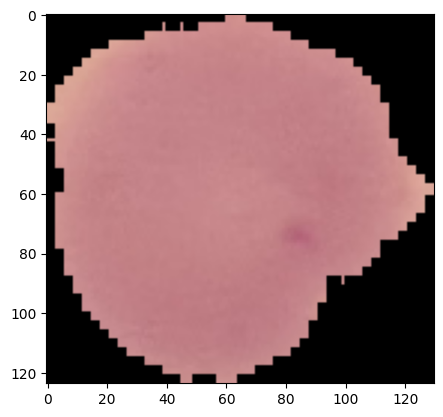

In [ ]:
original_image, label = next(iter(train_dataset))
print(label)
plt.imshow(original_image[0])

### Albumentations

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-yh83j14m
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-yh83j14m
  Resolved https://github.com/albu/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py) ... done


In [ ]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.OneOf([A.HorizontalFlip(),
             A.VerticalFlip(),], p = 0.3),
    A.RandomRotate90(),
    A.RandomGridShuffle(),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                             contrast_limit=0.2,
                             brightness_by_max=True,
                             always_apply=False, p=0.5),
    #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    #A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5)
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)

  return image

In [ ]:
def process_data(image, label):
  aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
  return aug_img, label

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

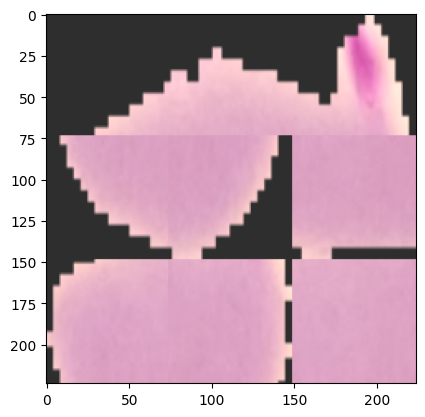

In [ ]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

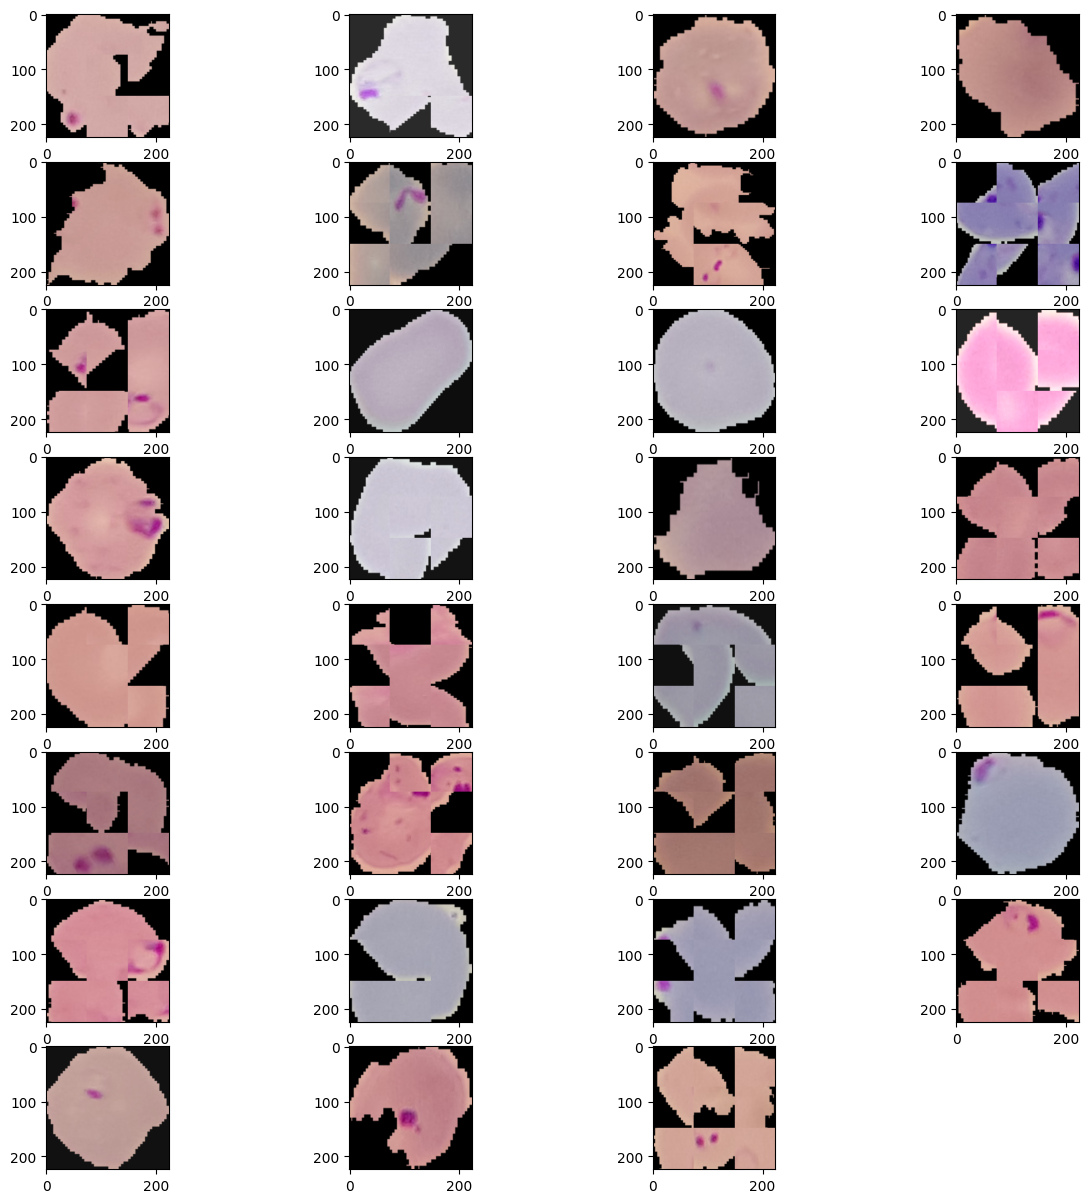

In [ ]:
plt.figure(figsize=(15,15))

for i in range(1, 32):
  plt.subplot(8, 4, i)
  plt.imshow(im[i])

### CutMix Data Augmentation

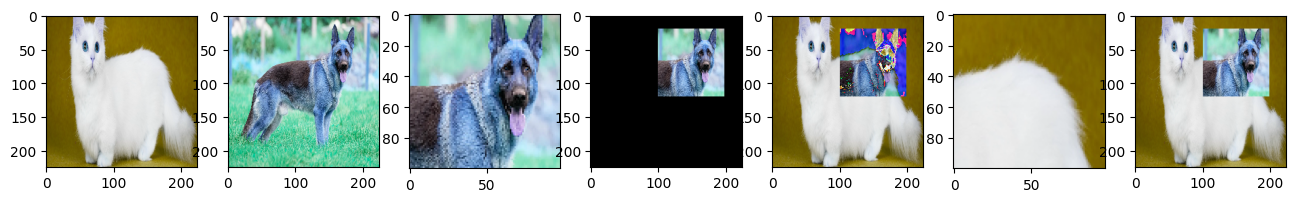

In [ ]:
# plt.figure(figsize=(16, 8))
# plt.subplot(1, 7, 1)
# image_1 = cv2.resize(cv2.imread('cat.jpg'), (IM_SIZE, IM_SIZE))
# plt.imshow(image_1)

# plt.subplot(1, 7, 2)
# image_2 = cv2.resize(cv2.imread('dog.jpg'), (IM_SIZE, IM_SIZE))
# plt.imshow(image_2)

# plt.subplot(1, 7, 3)
# crop = tf.image.crop_to_bounding_box(image_2, 20, 100, 100, 98)
# plt.imshow(crop)

# plt.subplot(1, 7, 4)
# image_4 = tf.image.pad_to_bounding_box(crop, 20, 100, IM_SIZE, IM_SIZE)
# plt.imshow(image_4)

# plt.subplot(1, 7, 5)
# image_4 = tf.image.pad_to_bounding_box(crop, 20, 100, IM_SIZE, IM_SIZE)
# plt.imshow(image_4 + image_1)

# plt.subplot(1, 7, 6)
# crop_cat = tf.image.crop_to_bounding_box(image_1, 20, 100, 100, 98)
# plt.imshow(crop_cat)

# plt.subplot(1, 7, 7)
# image_5 = tf.image.pad_to_bounding_box(crop_cat, 20, 100, IM_SIZE, IM_SIZE)
# plt.imshow(image_1 - image_5 + image_4 )

## WandB dataset Versioning

In [31]:
k=0
for data in dataset[0]:
  with open('dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
      np.savez(file, data)

  k += 1
  if(k%1000 ==0):
    print(k)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [43]:
with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:
  artifact = run.use_artifact('rember98cjs/Malaria-Detection/devout-oath-10', type='raw_data')
  artifact_dir = artifact.download()

wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


CommError: ignored

In [ ]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [1]:
def preprocess_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('rember98cjs/Malaria-Detection/devout-oath-10:v1', type='raw_data')
    artifact_dir = artifact.download()

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset",
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",

    )

    artifact_directory = "artifacts/new_dataset:v1/"

    dataset_x = []
    dataset_y = []

    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle=True)

        x, y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)

    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocess_data.new_file("prep_dataset") as file:
      np.savez(file, [dataset_x, dataset_y])

    run.log_artifact(preprocessed_data)

In [ ]:
preprocess_data()

In [39]:
load_original_data()

wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Adding directory to artifact (./dataset)... Done. 50.5s


wandb: ERROR Control-C detected -- Run data was not synced


In [42]:
print(artifact_dir)

NameError: ignored

## Data Splitting

In [ ]:
from wandb.sdk.interface.artifacts import ArtifactManifest
import wandb
run = wandb.init()
artifact = run.use_artifact('rember98cjs/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
artifact_dir = artifact.download()

In [ ]:
def split_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
    artifact_dir = artifact.download()

    train_data = wandb.Artifact(
        name = "train_dataset",
        type="preprocessed_data",
        description = "Training dataset",

    )
    val_data = wandb.Artifact(

        name = "val_dataset",
        type="preprocessed_data",
        description = "Validation dataset",

        )
    test_data = wandb.Artifact(
        name = "test_dataset",
        type="preprocessed_data",
        description = "Test dataset",

        )

    artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]


    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)


    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)

In [ ]:
split_data()

In [ ]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset",
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

# Model Creation and Training

## Wandb Model Versioning

### Untrained Model Versioning

In [ ]:
def log_model():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:


    untrained_model = wandb.Artifact(
        name = "Untrained_model",
        type="model",
        description = "The initial version of our lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    lenet_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [ ]:
log_model()

###Trained Model versioning

In [ ]:
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('neuralearn/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    trained_sequential_model = wandb.Artifact(
        name = "Trained_Sequential_model",
        type="model",
        description = "A trained version of our model",
        metadata = CONFIGURATION,
    )

    artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(im)
        dataset_y = arr[1]


    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

    d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

    train_d = (
        d
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )


    artifact = run.use_artifact('neuralearn/Malaria-Detection/Untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

    lenet_model = tf.keras.models.load_model(artifact_file)

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    lenet_model.fit(
        train_d,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbCallback()],
    )

    filename = 'lenet_trained.h5'
    lenet_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)

In [ ]:
train_and_log()

### Sequential API

In [ ]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_16 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 111, 111, 6)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_17 (Ba  (None, 109, 109, 16)     

### Functional API

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)


feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_34 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_35 (Ba  (None, 109, 109, 16)

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),


])

feature_extractor_seq_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_36 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_37 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

### Callable Model

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_8 (Flatten)         (None, 46656)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_38 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 10)                1010      
                                                       

### Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 =  Conv2D(filters = filters, kernel_size=kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv_2 =  Conv2D(filters = filters*2, kernel_size=kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_2 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 46656)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_42 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor =  FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x  = self.batch_1(x)
    x = self.dense_2(x)
    x  = self.batch_2(x)
    x = self.dense_3(x)

    return x
lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1, 224, 224, 3]))
lenet_sub_classed.summary()

Model: "lenet_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_3 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_10 (Flatten)        multiple                  0         
                                                                 
 dense_27 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_46 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_47 (Ba  multiple                

### Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self,input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape= (self.output_units,), initializer = "random_normal", trainable = True)


  def call(self, input_features):
    pre_output = tf.matmul(input_features, self.w) + self.b
    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output

IM_SIZE = 224
letnet_custom_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    NeuralearnDense(100, activation = "relu"),
    BatchNormalization(),

    NeuralearnDense(10, activation = "relu"),
    BatchNormalization(),
    NeuralearnDense(1, activation = "sigmoid")

])

letnet_custom_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_48 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_49 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

## Callbacks

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [ ]:
class LogImagesCallbackTensorBoard(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image = tf.image.decode_png(buffer.getvalue(), channels=3)
    image = tf.expand_dims(image, axis = 0)

    CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
    IMAGE_DIR = './logs/' + CURRENT_TIME + '/images'
    image_writer = tf.summary.create_file_writer(IMAGE_DIR)

    with image_writer.as_default():
      tf.summary.image("Training data", image, step = epoch)


In [ ]:
class LogImagesCallbackWandBPlot(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    pred = []

    for i in range(len(predicted)):
      if(predicted[i][0] < 0.5):
        pred.append([1, 0])
      else:
        pred.append([0, 1])

    pred = np.array(pred)


    # wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(
    #     probs=pred,
    #     y_true=labels,
    #     class_names=["Parasitized", "Uninfected" ])})

    wandb.log({"ROC Curve": roc_curve(
        y_true=labels,
        y_probas=pred,
        labels=["Parasitized", "Uninfected" ],
    )})

    wandb.log({'loss':logs['loss']})

In [ ]:
class LogImagesCallbackWandB(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])

    threshold = 0.5

    cm = confusion_matrix(labels, predicted > threshold)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image_array = tf.image.decode_png(buffer.getvalue(), channels=3)

    images = wandb.Image(image_array, caption="Confusion Matrix for epoch: {}".format(epoch))

    wandb.log({"Confusion Matrix": images})


### CSVLogger

In [ ]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

### EarlyStoping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

### LearningRateScheduler

In [ ]:
def scheduler(epoch, lr):

  if epoch <= 1:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

###ModelCheckpointing

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_precision', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch',
)

###ReduceLearningRateOnPlateau

In [ ]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=1
)

## Tensorboard

In [ ]:
pip install -U tensorboard_plugin_profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.4 MB/s eta 0:00:00


In [ ]:
rm -rf ./logs/

In [ ]:

CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [ ]:
LOG_DIR = './logs/' + CURRENT_TIME
print(LOG_DIR)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq = 1, profile_batch = '100,132')

./logs/081123 - Nov111699479682


## Custom Metric Class

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self, name='Custom_Accuracy', FACTOR=1):
    super(CustomAccuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name=name, initializer= 'zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype= tf.float32), y_pred)*self.FACTOR

    self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype = tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

## Custom Metric Method (without parameters)

In [ ]:
def custom_accuracy(y_true, y_pred):
  print(binary_accuracy(y_true, y_pred))
  return binary_accuracy(y_true, y_pred)

## Custom Metric Method (with Parameters)

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y,true, y_pred):
    return binary_accuracy(y_true, y_pred)*FACTOR
  return metric

## Custom Loss Class

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)*self.FACTOR

##Custom Loss Method (with parametres)

In [ ]:
FACTOR = 1
def custom_bce(FACTOR):
  def loss(y,true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* FACTOR
  return loss

## Custom Loss Method (without parametres)

In [ ]:
#@tf.function
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

## Model Training

In [ ]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [ ]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate= CONFIGURATION['LEARNING_RATE']),
                         loss=BinaryCrossentropy(),
                         metrics= metrics,
                        # run_eagerly=True    #----> ativate this for make the model more debugable
                    )

In [ ]:
lenet_sub_classed.compile(optimizer = Adam(learning_rate = 0.01),
              loss=BinaryCrossentropy(),
              metrics = 'accuracy')

In [ ]:
history = lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs = 3, #CONFIGURATION['N_EPOCHS'],
                          verbose = 1,
                          callbacks = [LogImagesCallbackWandB()])

Epoch 1/3
127/689 [====>.........................] - ETA: 11:14 - loss: 0.2222 - tp: 1936.0000 - fp: 207.0000 - tn: 1791.0000 - fn: 130.0000 - accuracy: 0.9171 - precision: 0.9034 - recall: 0.9371 - auc: 0.9680

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

In [ ]:
history_func = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs = 20, verbose = 1)

## Hyperparameter Tuning with WandB

In [25]:
sweep_config = {
    "name": "Malaria-Prediction-Sweep",
    "method": "random",
    "metric": {
        "name" : "accuracy",
        "goal" : "maximize",
    },
    "parameters" : {
        "N_DENSE_1": {
            "values" : [16, 32, 64, 128]
        },
        "N_DENSE_2" : {
            "values" : [16, 32, 64, 128]
        },
        "DROPOUT_RATE" : {
            "min": 0.1,
            "max": 0.4
        },
        "REGULARIZATION_RATE" : {
            "distribution": "uniform",
            "min": 0.001,
            "max": 0.1
        },
        "LEARNING_RATE": {
            "distribution": "uniform",
            "min": 1e-4,
            "max": 1e-2
        },
    }}


sweep_id = wandb.sweep(sweep_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 957hs2zq
Sweep URL: https://wandb.ai/rember98cjs/uncategorized/sweeps/957hs2zq


In [26]:
IM_SIZE = 224
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (224, 224, 3)),

    Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    Dropout(rate = config['DROPOUT_RATE'] ),

    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D (pool_size = 1, strides= 2),

    Flatten(),

    Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(config['REGULARIZATION_RATE'])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [27]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 3,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32,
}

In [28]:
def train():
  with wandb.init() as run:

    with wandb.init(project="Malaria-Detection", entity="rember98cjs", config=CONFIGURATION) as run:

      config = wandb.config
      model = model_tune(config)
      model.compile(optimizer= Adam(learning_rate = config.LEARNING_RATE),loss = 'binary_crossentropy', metrics=['accuracy'])
      model.fit(val_dataset, epochs=config.N_EPOCHS, callbacks = [WandbCallback()])

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: g7g2u953 with config:
wandb: 	DROPOUT_RATE: 0.16666582406740588
wandb: 	LEARNING_RATE: 0.0016201850477272084
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.06809821625213934
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: ERROR Run g7g2u953 errored: NameError("name 'DROPOUT_RATE' is not defined")
wandb: Agent Starting Run: wwenghut with config:
wandb: 	DROPOUT_RATE: 0.21819280206579467
wandb: 	LEARNING_RATE: 0.0069636488148330285
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 32
wandb: 	REGULARIZATION_RATE: 0.08337167082383
wandb: Currently logged in as: rember98cjs (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: ERROR Run wwenghut errored: NameError("name 'DROPOUT_RATE' is not defined")
wandb: Agent Starting Run: t18f1mga with config:
wandb: 	DROPOUT_RATE: 0.29777142974158954
wandb: 	LEARNING_RATE: 0.002420645492099464
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 32
wandb: 	REGULARIZATION_RATE: 0.06717970350054882
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: ERROR Run t18f1mga errored: NameError("name 'DROPOUT_RATE' is not defined")
wandb: Agent Starting Run: kst6bxod with config:
wandb: 	DROPOUT_RATE: 0.1017606171761054
wandb: 	LEARNING_RATE: 0.008040840241355308
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 128
wandb: 	REGULARIZATION_RATE: 0.0676344490923549
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: ERROR Run kst6bxod errored: NameError("name 'DROPOUT_RATE' is not defined")
wandb: Agent Starting Run: 3fcd6adt with config:
wandb: 	DROPOUT_RATE: 0.3642688967886955
wandb: 	LEARNING_RATE: 0.0012782641782865228
wandb: 	N_DENSE_1: 32
wandb: 	N_DENSE_2: 64
wandb: 	REGULARIZATION_RATE: 0.03326919746932312
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: ERROR Run 3fcd6adt errored: NameError("name 'DROPOUT_RATE' is not defined")


## Hyperparameter Tuning

In [ ]:
# IM_SIZE = 224

# def model_tune(hparams):
#   lenet_model = tf.keras.Sequential([
#       InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

#       resize_rescale_layers,
#       #augment_layers,

#       Conv2D(filters = 6, kernel_size = 3, strides=1, padding="valid", activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
#       BatchNormalization(),
#       MaxPool2D(pool_size = 2, strides = 2),
#       Dropout(rate = hparams[HP_DROPOUT]),

#       Conv2D(filters = 16, kernel_size = 3, strides=1, padding="valid", activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
#       BatchNormalization(),
#       MaxPool2D(pool_size = 2, strides = 2),

#       Flatten(),
#       Dense(hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
#       BatchNormalization(),
#       Dropout(rate = hparams[HP_DROPOUT]),

#       Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
#       BatchNormalization(),
#       Dense(1, activation = "sigmoid")

#   ])

#   lenet_model.compile(
#       optimizer=hparams[HP_LEARNING_RATE],
#       loss='binary_crossentropy',
#       metrics=['accuracy'],
#   )

#   lenet_model.fit(val_dataset, epochs=1)
#   _, accuracy = lenet_model.evaluate(val_dataset)
#   return accuracy


In [ ]:
IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),

    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))


In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,

          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

31/87 [=========>....................] - ETA: 1:05 - loss: 0.8113 - accuracy: 0.5494

KeyboardInterrupt: ignored

## Custom Training Loop

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = CONFIGURATION['N_EPOCHS']

In [ ]:
CURRENT_TIME = datetime.datetime.now().strftime('%d%m%y - %h%m%s')
CUSTOM_TRAIN_DIR = './logs/' + CURRENT_TIME + '/custom/train'
CUSTOM_VAL_DIR = './logs/' + CURRENT_TIME + '/custom/val'

custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch, training = True)
      loss = custom_bce(y_batch, y_pred)
  #wandb.log({'loss':loss.numpy()})
  partial_derivatives = recorder.gradient(loss, lenet_model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model.trainable_weights))

  METRIC.update_state(y_batch, y_pred)
  return loss

@tf.function
def val_block(x_batch_val, y_batch_val):
    y_pred_val = lenet_model(x_batch_val, training = False)
    loss_val = custom_bce(y_batch_val, y_pred_val)
    METRIC_VAL.update_state(y_batch_val, y_pred_val)
    return loss_val

In [ ]:
def neuralearn(model,loss_function, METRIC, VAL_METRIC, OPTIMIZER, train_dataset, val_dataset, EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch))
    for step, (x_batch, y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch, y_batch)


    print("Training Loss", loss)
    print("The accuracy is:", METRIC.result())

    with custom_train_writer.as_default():
      tf.summary.scalar('Training Loss', data = loss, step = epoch)
    with custom_train_writer.as_default():
      tf.summary.scalar('Training Accuracy', data = METRIC.result(), step = epoch)
    #
    METRIC.reset_states()

    for (x_batch_val, y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val, y_batch_val)

    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())

    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Loss', data = loss_val, step = epoch)
    with custom_val_writer.as_default():
      tf.summary.scalar('Validation Accuracy', data = METRIC_VAL.result(), step = epoch)

    METRIC_VAL.reset_states()
  print("Training Complete!!!!")


In [ ]:
neuralearn(lenet_model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

In [ ]:
image = cv2.imread('cell.jpg')
print(image.shape)
image = tf.expand_dims(image, axis=0)
print(image.shape)

lenet_model.predict(image)

(130, 136, 3)
(1, 130, 136, 3)
1/1 [==============================] - 0s 17ms/step


array([[0.5017297]], dtype=float32)

## Visualizations

In [ ]:
%load_ext tensorboard

In [ ]:
tensorboard --logdir='./logs'

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-11-08 21:19:56.662562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 21:19:56.662650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 21:19:56.662689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 21:19:59.116441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf

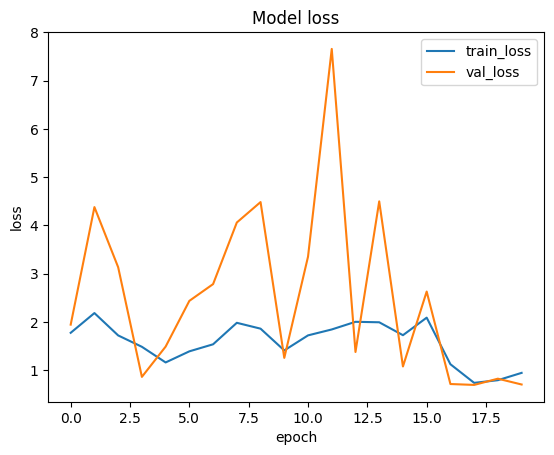

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
letnet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 4.0646 - accuracy: 0.5049


[4.064562797546387, 0.5048966407775879]

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(letnet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 21ms/step


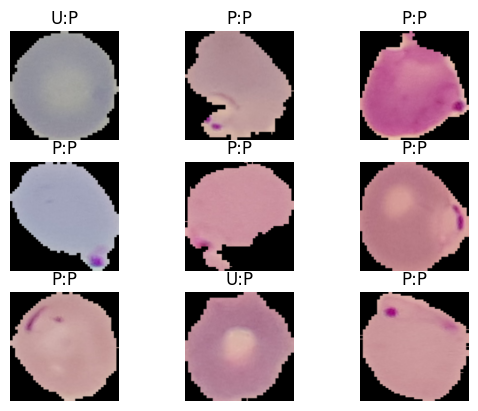

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(letnet_model.predict(image)[0][0])))

  plt.axis('off')

## Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:, 0, ...].shape)

In [ ]:
labels = np.array([i[0] for i in labels])

In [ ]:
print(labels)

In [ ]:
predicted = lenet_model.predict(np.array(inp)[:, 0, ...])
print(predicted[:,0])

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title('Confusion matrix- {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

## ROC Plots

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
# print(len(fp), len(tp), len(thresholds))
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip)
 plt.test(fp[i], tp[i], thresholds[i])
plt.show()

## Loading and Saving

In [ ]:
letnet_model.save("lenet")

In [ ]:
letnet_loaded_model = tf.keras.models.load_model("lenet")
letnet_loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

1/1 [==============================] - 0s 35ms/step


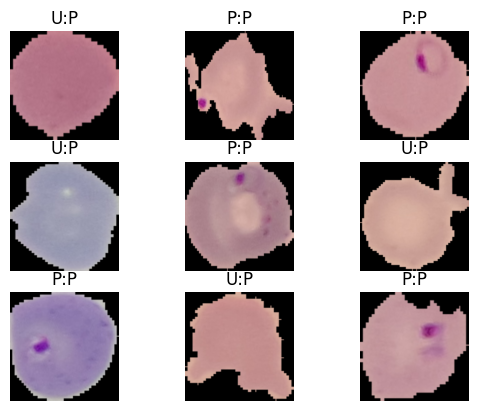

In [ ]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(letnet_loaded_model.predict(image)[0][0])))

  plt.axis('off')

In [ ]:
letnet_loaded_model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 4.0915 - accuracy: 0.5034


[4.091502666473389, 0.5034458041191101]

In [ ]:
letnet_model.save("lenet.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
lenet_loaded_model_hdf5 = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model_hdf5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [ ]:
letnet_model.save_weights("weights/lenet_weights")

In [ ]:
letnet_weights_model = letnet_model.load_weights("weights/lenet_weights")

In [ ]:
letnet_model.load_weights("weights/lenet_weights")
letnet_model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 4ms/step - loss: 4.0475 - accuracy: 0.5063


[4.047532558441162, 0.5063474774360657]

## Saving to Google Drive

In [ ]:
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab

In [ ]:
#!cp -r /content/drive/MyDrive/lenet_colab /content/lenet_colab/